In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity

import fittes as fts
import transport_signal_processing as tsp
from data_manager import DataManager

### Input parameters for clustering

In [38]:
path = "*K238A*150mV*TotA*3MGdmCl*/*0503*34*"

# number of clusters
N_clst = 4

# number of columns and rows for plot of each cluster
ncol = 2
nrow = 2

### Load data

In [39]:
selected_only = True
sigman = DataManager('database')
# load segments informations
sinfo_l = sigman.load_info(path, 's*')
# convert info to dataframe
df = pd.DataFrame(sinfo_l)
# keep only selected polymers in dataframe and signal info
df = df[(df['selected'] > (int(selected_only)-1))]
sinfo_l = [sinfo_l[i] for i in df.index.values]
df = df.reset_index(drop=True)
thing = pd.Series(df['id']).str.replace('-[0-9]', '', regex=True)
df['idd'] = df["date"].values+'_'+thing
# debug display
display(df)

# load core events
cores_all = []
reduced_all = []
stats_all = []
M = 0
N = 0
for i in range(len(sinfo_l)):
    # get path within the database
    sinfo = sinfo_l[i]
    curr_path = sigman.define_db_path(sinfo)
    # load cores & reduced and filter keep only selected ones
    m = sigman.load_data(curr_path, 's{}-selected'.format(sinfo['sid']))[0].astype(bool)
    c = sigman.load_data(curr_path, 's{}-core-events'.format(sinfo['sid']))[0][m]
    r = sigman.load_data(curr_path, 's{}-reduced-events'.format(sinfo['sid']))[0][m]
    s = sigman.load_data(curr_path, 's{}-stats'.format(sinfo['sid']))[0][m]
    # get selected stats
    M += np.sum(m)
    N += m.shape[0]
    # process events
    for k in range(len(c)):
        # time [s] -> [ms]
        c[k][:,0] = 1e3 * c[k][:,0]
        r[k][:,0] = 1e3 * r[k][:,0]
        s[k][0] = 1e3 * s[k][0]
        # current -> relative current
        c[k][:,1] = 1e2 * c[k][:,1] / sinfo['mI_open']
        r[k][:,1] = 1e2 * r[k][:,1] / sinfo['mI_open']
        s[k][1] = 1e2 * s[k][1] / sinfo['mI_open']
        #s[k][2] = 1e2 * s[k][2] / sinfo['mI_open']
    
    # append data
    cores_all += list(c)
    reduced_all += list(r)
    stats_all += list(s)

# pack data
stats_all = np.array(stats_all)[:,:2]

# debug print
print("selected precentage: {:.1f}%".format(1e2*M/N))

,pore,temperature,voltage,polymer_name,date,channel,id,sid,segment_range,segment_duration,MODIFIED,mI_open,sI_open,N_events,N_cores,N_reduced,selected,ratio_sel,idd
0,K238A,25,150,TotA-3MGdmClpH40,20230503,001,34,0,"[0, 3618865]",36.18865,2023-08-18_15:34:18,208.054061,5.704902,484,484,484,1,0.878099,20230503_34
1,K238A,25,150,TotA-3MGdmClpH40,20230503,001,34,1,"[3633859, 9034396]",54.00537,2023-08-18_15:34:18,208.129317,5.695643,662,662,662,1,0.877644,20230503_34


selected precentage: 87.8%


### Clustering

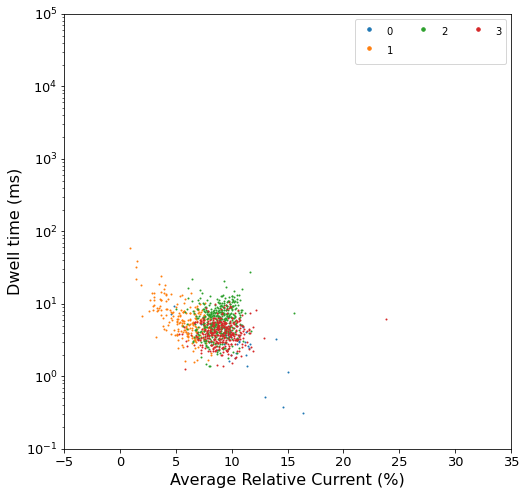

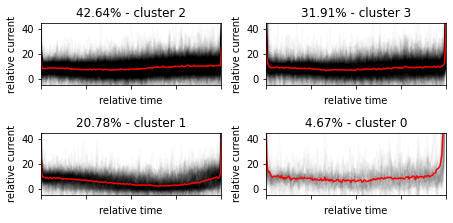

100.0


In [40]:
# parameters
N_interp = 200

# interpolate events
X = np.array([tsp.signals.downsample(x[:,1], N_interp) for x in cores_all])
# clustering
clst = KMeans(N_clst)
clst.fit(X)

# get labels
y = clst.labels_

# split by clusters
X_l = []
ic_l = []
for i in np.unique(y):
    ids = np.where(y == i)[0]
    X_l.append(X[ids])
    ic_l.append(ids)

# get cluster centers
Xc = clst.cluster_centers_

# plot
fsz = 16
plt.figure(figsize=(8,8))
for i in np.unique(y):
    ids = np.where(y == i)[0]
    plt.semilogy(stats_all[ids,1], stats_all[ids,0], '.', ms=2.0, label=str(i))

plt.legend(loc='best', ncol=3, handleheight=2.4, labelspacing=0.05, markerscale=3.5)
plt.xlim(-5.0, 35.0) #100
plt.ylim(0.1, 100000.0) #10000
plt.xlabel('Average Relative Current (%)',fontsize = fsz)
plt.ylabel('Dwell time (ms)',fontsize = fsz)
plt.yticks(fontsize= fsz-3)
plt.xticks(fontsize= fsz-3)
#plt.savefig('graphs/{}_clusteredScatter.png'.format(path), dpi=300, transparent=True)
plt.show()

# check
assert ncol*nrow == N_clst

# define x axis points
t = np.linspace(0.0, 1.0, N_interp)

# sort by cluster size
ids_srtd = np.argsort([1e2*x.shape[0]/M for x in X_l])[::-1]

# plots

plt.figure(figsize=(3.2*ncol,1.6*nrow))
ptot = 0.0
for i in range(nrow):
    for j in range(ncol):
        # get 1d index
        k_ = ncol*i+j
        k = ids_srtd[k_]
        # subplot
        plt.subplot(nrow, ncol, k_+1)
        for x in X_l[k]:
            plt.plot(t, x, 'k-', alpha=0.025)
        plt.plot(t, Xc[k], 'r-')
        plt.xlim(0.0, 1.0)
        plt.ylim(-5.0,45.0) #-10.0, 30.0
        plt.xticks([0.0, 0.25, 0.5, 0.75, 1.0], ['', '', '', '', ''])
        plt.yticks([0.0, 20.0, 40.0], [0, 20, 40]) #add 40 when applicable
        #plt.yticks([0.0, 50.0, 100.0], [0, 50, 100])
        plt.xlabel('relative time')
        plt.ylabel('relative current')
        plt.title('{:.2f}% - cluster {}'.format(1e2*X_l[k].shape[0]/M, k))
        ptot += 1e2*X_l[k].shape[0]/M

plt.tight_layout()
plt.savefig('graphs/{}cluster_overlays_15kHz.png'.format(path), dpi=300)
plt.show()

# debug print
print(ptot)

47.31610337972167


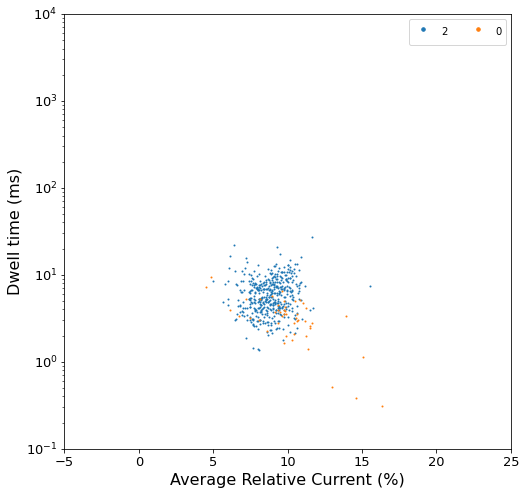

In [41]:
# Showing the clusters of interest and the percentage
plt.figure(figsize=(8,8))
prop_sel = 0
for i in [2,0]: # add the cluster number #3,9,6,1,10,8,7
    ids = np.where(y == i)[0]
    plt.semilogy(stats_all[ids,1], stats_all[ids,0], '.', ms=2.0, label=str(i))
    prop_sel += 1e2*X_l[i].shape[0]/M

print(prop_sel)

# plot
fsz = 16
plt.legend(loc='best', ncol=3, handleheight=2.4, labelspacing=0.05, markerscale=3.5)
plt.xlim(-5.0, 25.0) #100
plt.ylim(0.1, 10000.0)
plt.xlabel('Average Relative Current (%)',fontsize = fsz)
plt.ylabel('Dwell time (ms)',fontsize = fsz)
plt.yticks(fontsize= fsz-3)
plt.xticks(fontsize= fsz-3)
#plt.savefig('graphs/{}_clusteredScatter_Selected.png'.format(path), dpi=300)
plt.show()


## select clusters 

In [37]:
# what clusters should be merged and used to fit the dwell time?
clust_sel = np.array([2,0,1,4]) # 6,11,0,7,8 1,2,3,4,5,6,7,8,9,10,11

#parameters for fitting 
#exp decay fit
dt = 1e-5
xlims_on = (0.0, 1000.0) #130 #50 TotA pH 40
bins_on = 25 #25
#gaussian fit
lxlims_on = (-0.5, 2.5) #2.5
lbins_on = 30 #25

### fit dwell time of selected clusters

4 events selected


<ipython-input-38-fe8e6ed741d2>:27: RuntimeWarning: divide by zero encountered in log10
  plt.plot(x_on, np.log10(h_on), '.-')


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

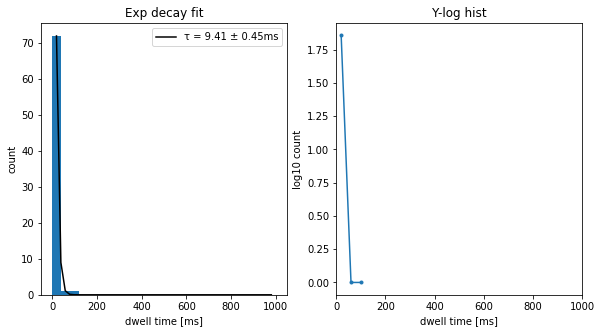

In [38]:
u = clst.labels_
results = []
dwt =[]
for i,p in enumerate(clust_sel):
    ids = np.where(u == p)[0]
    # get data
    dwt.append(stats_all[ids,0].copy())
print("{} events selected".format(len(dwt)))
dwt_on = np.concatenate(dwt)    
# fit durations

x_on, y_on, a_on, err_on = fts.exp_dist_fit(dwt_on, xlims_on, bins_on)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(dwt_on, range=xlims_on, bins=bins_on)
plt.plot(x_on, y_on, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(1.0/a_on, err_on))
plt.legend(loc='best')
plt.xlabel('dwell time [ms]')
plt.ylabel('count')
plt.title('Exp decay fit')

h_on, x_on = np.histogram(dwt_on, range=xlims_on, bins=bins_on)
x_on = 0.5*(x_on[:-1] + x_on[1:])

plt.subplot(132)
plt.plot(x_on, np.log10(h_on), '.-')
plt.xlim(xlims_on)
plt.xlabel('dwell time [ms]')
plt.ylabel('log10 count')
plt.title('Y-log hist')


ldwt_on = np.log10(dwt_on)
x_on, y_on, a_on, err_on = fts.gauss_dist_fit(ldwt_on, lxlims_on, lbins_on)

plt.subplot(133)
plt.hist(ldwt_on, range=lxlims_on, bins=lbins_on)
plt.plot(x_on, y_on, 'k-', label='τ = {:.2f} ± {:.2f}ms'.format(a_on, err_on))
plt.legend(loc='best')
plt.xlabel('log10 dwell time [ms]')
plt.ylabel('count')
plt.title('Gauss fit')
plt.tight_layout()
#plt.savefig('graphs/{}_dwt_fit_ClustSel.png'.format(path), dpi=300)